## import neccessariy liberaries

In [315]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import logging

### Load Data

In [316]:
dataset = pd.read_excel("/content/WAR data set.xlsx")
dataset.head()

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L),Water Absorption reduction (%)
0,35,9.5,0.147273,3,33.944,20.0,15.0
1,25,8.2,0.050909,3,25.458,20.0,8.0
2,30,9.5,0.550000,3,33.944,20.0,22.0
3,30,9.5,0.550000,7,33.944,20.0,27.3
4,30,9.5,0.550000,10,33.944,20.0,28.6


## EDA- Exploratory data Analysis

In [317]:
#independent and target variables
X = dataset.drop('Water Absorption reduction (%)', axis = 1)
y = dataset['Water Absorption reduction (%)']

In [318]:
# Train _Test Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 96
Testing set size: 13
Validation set size: 12


In [319]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

display(X_train_scaled.head())

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L)
0,0.246462,1.329710,0.173882,0.379775,-0.457001,-0.750500
1,-0.521732,-1.077005,-0.957378,-0.877411,0.251890,-0.054250
2,-1.289925,-1.077005,-0.222793,-0.248818,-0.457001,-1.307501
3,0.246462,1.329710,0.173882,1.846493,-0.457001,-0.750500
4,-0.521732,0.078218,-1.439265,-0.458349,-1.874782,-0.750500


In [320]:
def add_noise(data, noise_factor=0.05, num_samples=96, random_state=42):
    augmented_data = []
    np.random.seed(random_state)
    for _ in range(num_samples):
        random_index = np.random.randint(0, len(data))
        sample = data.iloc[random_index]
        noise = np.random.randn(data.shape[1]) * noise_factor
        augmented_sample = sample + noise
        augmented_data.append(augmented_sample)

    augmented_data = pd.DataFrame(augmented_data, columns=data.columns)
    return augmented_data

X_train_augmented = add_noise(X_train, num_samples=96, random_state=42)

y_train_augmented = y_train.iloc[np.random.choice(len(y_train), 96, replace=False)]


X_train_combined = pd.concat([X_train, X_train_augmented], ignore_index=True)
y_train_combined = pd.concat([y_train, y_train_augmented], ignore_index=True)

print(f"Original training set size (Noise Injection): {X_train.shape[0]}")
print(f"Augmented training set size (Noise Injection): {X_train_augmented.shape[0]}")
print(f"Combined training set size (Noise Injection): {X_train_combined.shape[0]}")

print("\nShapes after noise injection augmentation:")
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Original training set size (Noise Injection): 96
Augmented training set size (Noise Injection): 96
Combined training set size (Noise Injection): 192

Shapes after noise injection augmentation:
Shape of X_train_combined: (192, 6)
Shape of y_train_combined: (192,)
Shape of X_test: (13, 6)
Shape of y_test: (13,)
Shape of X_val: (12, 6)
Shape of y_val: (12,)


In [321]:
display(X_train_augmented.head())
print(X_train_augmented.shape)

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L)
109,24.944406,7.515945,0.513952,1.050526,37.970956,19.973742
40,35.073119,9.076936,0.878045,21.030172,34.887435,59.991807
12,25.003376,6.928763,0.372781,1.005546,49.942450,20.018785
120,24.898664,8.055971,1.138960,0.944945,38.056511,60.018656
39,34.988527,9.019467,0.936744,14.054600,35.038903,60.059682


(96, 6)


In [322]:
display(y_train_augmented.head())
display(y_train_augmented.shape)

,Water Absorption reduction (%)
56,9.00
0,15.00
1,8.00
37,2.97
118,46.20


(96,)

### RF Model Devlopment

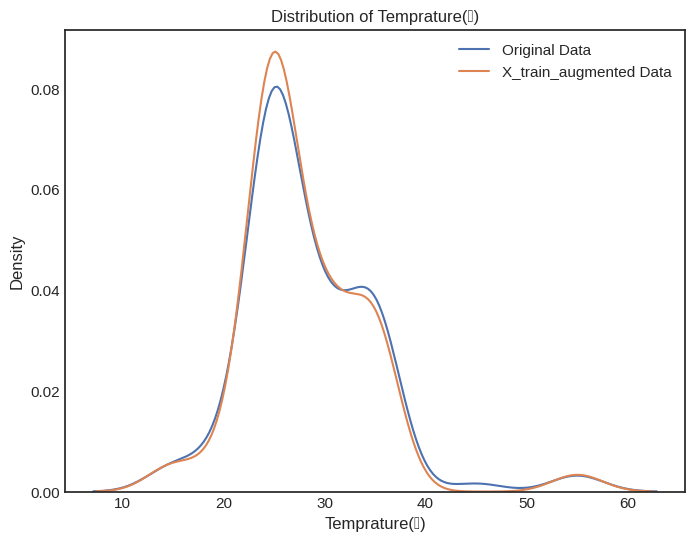

In [346]:
selected_feature = 'Temprature(℃)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

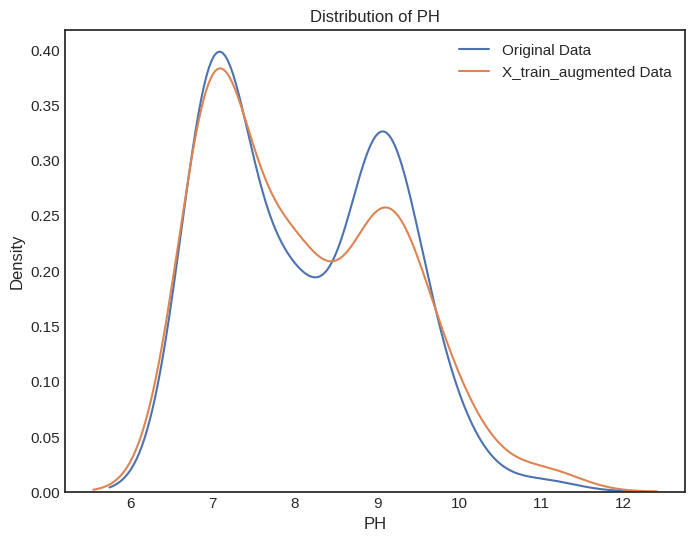

In [324]:
selected_feature = 'PH'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

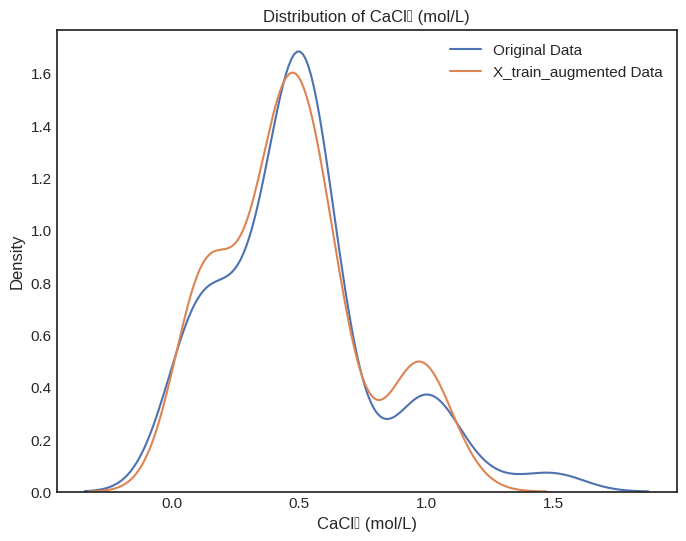

In [325]:
selected_feature = 'CaCl₂ (mol/L)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

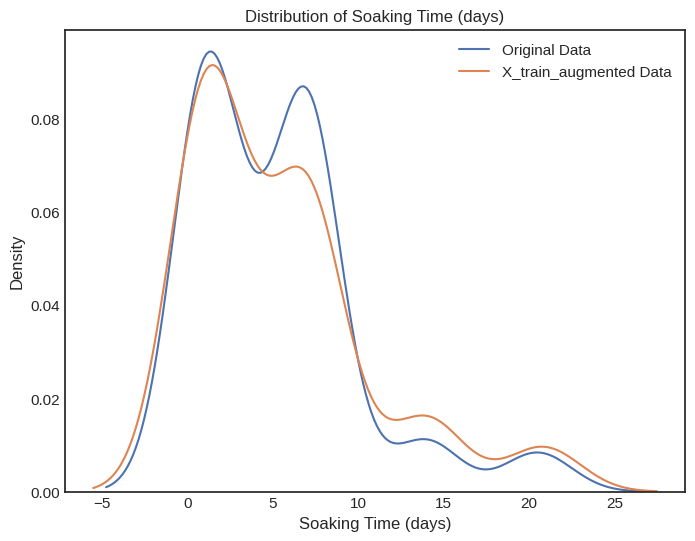

In [326]:
selected_feature = 'Soaking Time (days)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

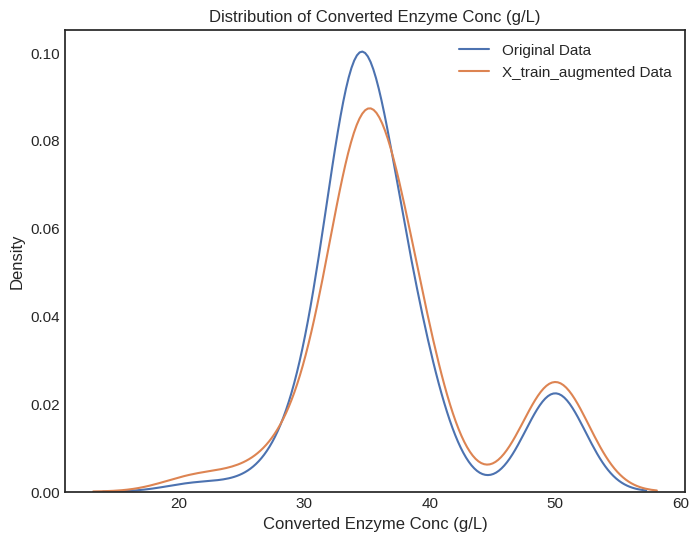

In [327]:
selected_feature = 'Converted Enzyme Conc (g/L)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

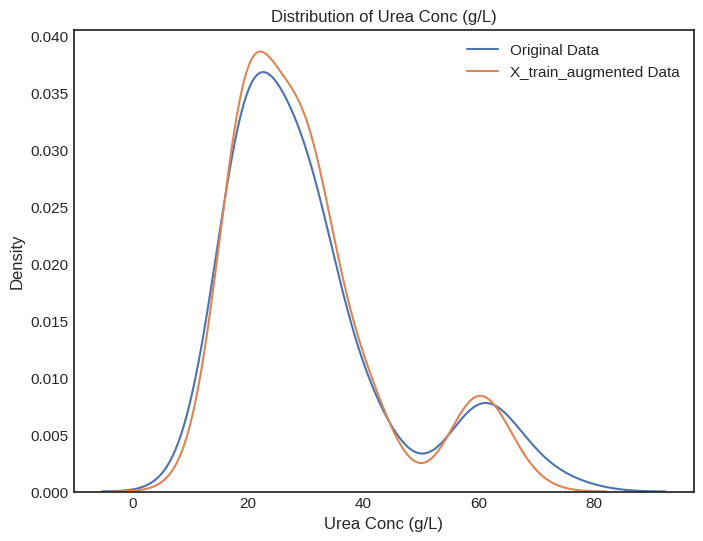

In [328]:
selected_feature = 'Urea Conc (g/L)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(X_train[selected_feature], ax=ax, label='Original Data')
sns.kdeplot(X_train_augmented[selected_feature], ax=ax, label='X_train_augmented Data')
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

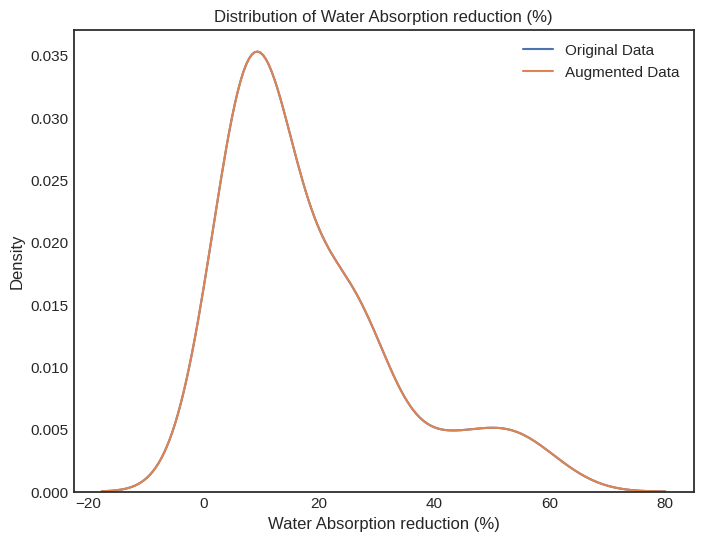

In [329]:
selected_feature = 'Water Absorption reduction (%)'
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')
sns.kdeplot(y_train, ax=ax, label='Original Data')
sns.kdeplot(y_train_augmented, ax=ax, label='Augmented Data') # Changed label for clarity
ax.set_xlabel(selected_feature)
ax.set_ylabel("Density")
ax.set_title(f"Distribution of {selected_feature}")
ax.legend()
plt.show()

In [330]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()
RF = RandomForestRegressor(max_depth= 15, min_samples_split=6, max_features= 1.0,random_state=42)

In [331]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [332]:
RF.fit(X_train_combined, y_train_combined)

RandomForestRegressor(max_depth=15, min_samples_split=6, random_state=42)

In [333]:
y_pred_train = RF.predict(X_train_combined)
y_pred_test = RF.predict(X_test)
y_pred_val=RF.predict(X_val)

### Model Evaluation

In [334]:
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train, RF.predict(X_train))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train, RF.predict(X_train))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train, RF.predict(X_train)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train, RF.predict(X_train)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test, RF.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, RF.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, RF.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, RF.predict(X_test)):.4f}')
print("-" * 30)

# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, RF.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, RF.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val, RF.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, RF.predict(X_val)):.4f}')


Training Set Metrics:
The RMSE on the training dataset is: 3.8435
The MSE on the training dataset is: 14.7723
The MAE on the training daset is: 2.9285
The r2_score on the training dataset is: 0.9310
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 6.2754
The MSE on the testing dataset is: 39.3804
The MAE on the testing dataset is: 3.7271
The r2_score on the testing dataset is: 0.8673
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 7.9731
The MSE on the validation dataset is: 63.5707
The MAE on the validation dataset is: 5.6458
The r2_score on the validation dataset is: 0.8226


## Hypeparamter Tunning (Optimization)

In [335]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [336]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [337]:
# Perform GridSearchCV to find the best parameters
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=64),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)


In [338]:
# Fit GridSearchCV
rf_grid.fit(X_train_combined, y_train_combined)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=64), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [339]:
# Print the best parameters
print("Best Parameters from Grid Search:", rf_grid.best_params_)

Best Parameters from Grid Search: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [340]:
# Train final optimized model with best parameters
best_rf = rf_grid.best_estimator_


In [341]:
y_pred_train = rf_grid.predict(X_train_combined)
y_pred_test = rf_grid.predict(X_test)
y_pred_val=rf_grid.predict(X_val)

In [342]:
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train, rf_grid.predict(X_train))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train, rf_grid.predict(X_train))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train, rf_grid.predict(X_train)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train, rf_grid.predict(X_train)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test,rf_grid.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, rf_grid.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, rf_grid.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, rf_grid.predict(X_test)):.4f}')
print("-" * 30)
# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, rf_grid.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, rf_grid.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val,rf_grid.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, rf_grid.predict(X_val)):.4f}')


Training Set Metrics:
The RMSE on the training dataset is: 2.8685
The MSE on the training dataset is: 8.2285
The MAE on the training daset is: 2.1073
The r2_score on the training dataset is: 0.9616
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 5.8963
The MSE on the testing dataset is: 34.7666
The MAE on the testing dataset is: 3.5413
The r2_score on the testing dataset is: 0.8828
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 7.3444
The MSE on the validation dataset is: 53.9408
The MAE on the validation dataset is: 5.3981
The r2_score on the validation dataset is: 0.8494


### Actual vs Predicted Capacity

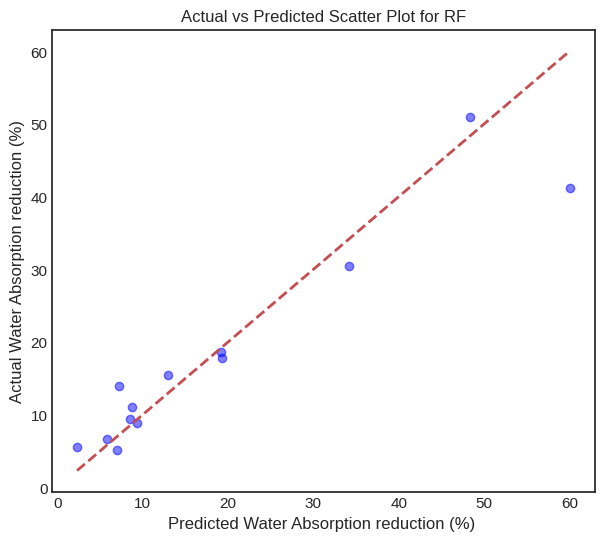

In [343]:
plt.figure(figsize=(7, 6))
plt.style.use('seaborn-v0_8-white')
y_pred = rf_grid.predict(X_test)
plt.scatter(y_test, y_pred, color="blue", alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit")
plt.xlabel("Predicted Water Absorption reduction (%) ")
plt.ylabel("Actual Water Absorption reduction (%)")
plt.title("Actual vs Predicted Scatter Plot for RF")
plt.show()

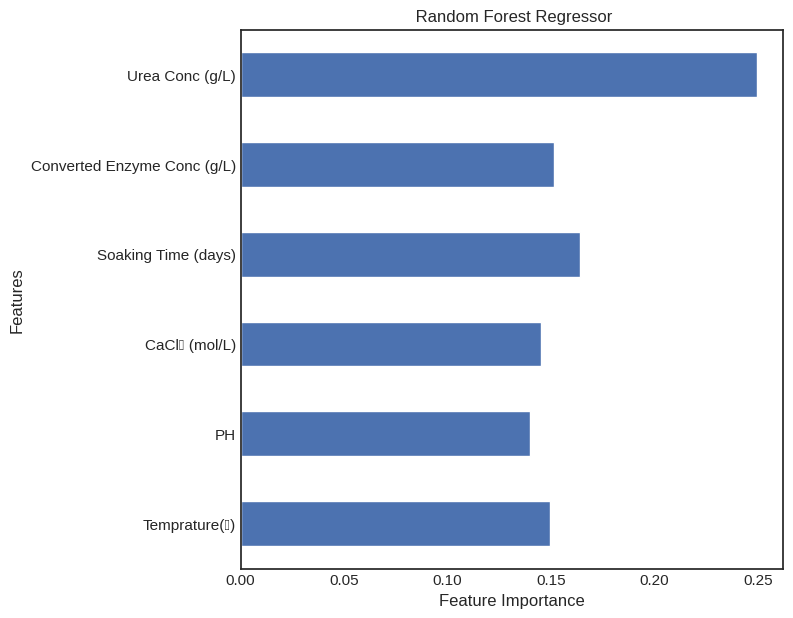

In [344]:
importances = pd.Series(rf_grid.best_estimator_.feature_importances_ , index=X.columns)
importances.plot(kind = 'barh', figsize=(7,7))
plt.style.use('seaborn-v0_8-whitegrid')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title(" Random Forest Regressor")
plt.show()